In [3]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re
import pandas as pd
import numpy as np 
import os 

In [4]:
#종목코드 
url = "http://comp.fnguide.com/XML/Market/CompanyList.txt"
resp = requests.get(url)
json_data = resp.content

my_dic = json.loads(json_data, strict=False)
data = my_dic['Co']

codes = pd.DataFrame()
for i in range(0, len(data)):
    d = {'code' : [data[i]['cd'][1:len(data[i]['cd'])]],
         'name' : [data[i]['nm']]}
    temp = pd.DataFrame(d)
    codes = pd.concat([temp, codes], axis = 0)
codes.head()

,code,name
0,500023,신한 콩 선물 ETN(H)
0,500039,신한 코스피 콘도르 4/10% ETN
0,500021,신한 천연가스 선물 ETN(H)
0,500024,신한 인버스 콩 선물 ETN(H)
0,500022,신한 인버스 천연가스 선물 ETN(H)


In [5]:
def deep_crawl(url):
    try:
        resp = requests.get(str(url))
        html = resp.text

        soup = BeautifulSoup(html, "html5lib")
        temp = soup.select("#body")
        return temp[0].text
    except:
        return 0

def crawl(code, page):
    try :
        time.sleep(2)

        url = "https://finance.naver.com/item/board.nhn?code="+code+"&page="+page
        resp = requests.get(url)
        html = resp.text

        soup = BeautifulSoup(html, "html5lib")

        deep_url=[]
        for anchor in soup.findAll('a', href=re.compile("^(/item/board_read.nhn?)")):
            deep_url.append(anchor['href'])

        opinion = soup.select("#content > div.section.inner_sub > table.type2 > tbody > tr > td.tc > span")
        rec_count = soup.select("#content > div.section.inner_sub > table.type2 > tbody > tr > td > strong")
        sec_count = soup.select("#content > div.section.inner_sub > table.type2 > tbody > tr > td:nth-of-type(5) > span.tah")
        date = soup.select("#content > div.section.inner_sub > table.type2 > tbody > tr > td:nth-of-type(1) > span.tah")

        df = pd.DataFrame()
        for i in range(0, len(opinion)):
            temp = str(page) + "번째 페이지의 "+str(i)+"번째_게시글"
            d = {'rank' : [temp],
                 'date' : [date[0].text],
                 'opinion': [opinion[0].text],
                 'description' : [deep_crawl("https://finance.naver.com"+deep_url[i])],
                 'rec': [rec_count[0].text], 
                 'click_count': [sec_count[0].text]}

            temp = pd.DataFrame(d)
            df = pd.concat([temp, df],axis=0)
        df['code'] = str(code)
        return df
    except:
        return 0

In [79]:
df = pd.DataFrame()
for i in range(2500,2502):
    print("\n종목명 : %s"%codes['name'].iloc[i])
    for j in range(1,3):
        print("%d 번째 페이지 크롤링 중..."%j)
        temp = crawl(codes['code'].iloc[i],str(j))
        df = pd.concat([temp,df], axis= 0)


종목명 : 덕산하이메탈
1 번째 페이지 크롤링 중...
2 번째 페이지 크롤링 중...

종목명 : 덕산네오룩스
1 번째 페이지 크롤링 중...
2 번째 페이지 크롤링 중...


In [7]:
df.head()

,click_count,date,description,opinion,rank,rec,code
0,84,2018.11.23 20:14,ㅎㅎㅎ 뭐가 있네 있어 ㅋ,의견없음,1번째 페이지의 19번째_게시글,0,234100
0,84,2018.11.23 20:14,ㅋㅋㅋㅋ,의견없음,1번째 페이지의 18번째_게시글,0,234100
0,84,2018.11.23 20:14,"세력들 1,500원부터 매집해 지금 마지막 패데기 시점이고\n\n지들끼리 사고 팔고...",의견없음,1번째 페이지의 17번째_게시글,0,234100
0,84,2018.11.23 20:14,뇌동매매 하는 거지같은 개미들아 ^^ \n\n잘먹고 잘간다~\n\n늬들이 있어서 행...,의견없음,1번째 페이지의 16번째_게시글,0,234100
0,84,2018.11.23 20:14,ㅎㅎㅎ,의견없음,1번째 페이지의 15번째_게시글,0,234100


In [51]:
import json

class KnuSL():
    def data_list(wordname):
        with open('C:/Users/user/Desktop/Dev/SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
                data = json.load(f)
        result = ['None','None']
        for i in range(0, len(data)):
            if data[i]['word'] == wordname:
                result.pop()
                result.pop()
                result.append(data[i]['word_root'])
                result.append(data[i]['polarity'])	

        r_word = result[0]
        s_word = result[1]

        return r_word, s_word

In [77]:
ksl = KnuSL

print("\nKNU 한국어 감성사전입니다~ :)")
print("사전에 단어가 없는 경우 결과가 None으로 나타납니다!!!")
print("-2:매우 부정, -1:부정, 0:중립 or Unkwon, 1:긍정, 2:매우 긍정")

wordname = df['description']
result = []
wordname = wordname.apply(lambda x: x.split(' '))
for i in range(0, len(wordname)):
    temp = wordname.iloc[i]
    temp2 = 0
    for j in range(0, len(temp)):
        r_word, s_word = ksl.data_list(temp[j])
        try:
            temp2 = temp2+int(s_word)
        except:
            pass
    result.append(temp2)


KNU 한국어 감성사전입니다~ :)
사전에 단어가 없는 경우 결과가 None으로 나타납니다!!!
-2:매우 부정, -1:부정, 0:중립 or Unkwon, 1:긍정, 2:매우 긍정


In [73]:
result = pd.DataFrame(result)
result.columns = ['Sentiment']

df = df.reset_index().drop(['index'], axis= 1)
df = pd.concat([df, result], axis=1)

In [75]:
df.head()

,click_count,date,description,opinion,rank,rec,code,0
0,84,2018.11.23 20:14,ㅎㅎㅎ 뭐가 있네 있어 ㅋ,의견없음,1번째 페이지의 19번째_게시글,0,234100,0
1,84,2018.11.23 20:14,ㅋㅋㅋㅋ,의견없음,1번째 페이지의 18번째_게시글,0,234100,0
2,84,2018.11.23 20:14,"세력들 1,500원부터 매집해 지금 마지막 패데기 시점이고\n\n지들끼리 사고 팔고...",의견없음,1번째 페이지의 17번째_게시글,0,234100,0
3,84,2018.11.23 20:14,뇌동매매 하는 거지같은 개미들아 ^^ \n\n잘먹고 잘간다~\n\n늬들이 있어서 행...,의견없음,1번째 페이지의 16번째_게시글,0,234100,5
4,84,2018.11.23 20:14,ㅎㅎㅎ,의견없음,1번째 페이지의 15번째_게시글,0,234100,0


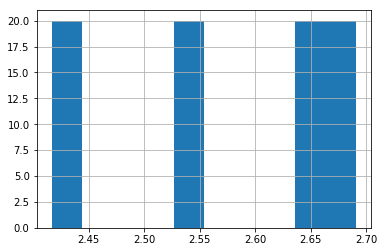

In [87]:
np.log10(temp['click_count'].astype(np.int)).hist()

In [ ]:
date